In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# fpath = "F:\\pp1_data_processing\\2023-05-22_21-17-37 dac showing pacman.csv"
# fpath = "F:\\pp1_data_processing\\2023-05-22_22-36-06 dac showing pacman 200MHz.csv"
# fpath = "C:\\Users\\ionca\\Desktop\\pp1\\2023-05-23_17-58-21 dac 200MHz one line.csv"
fpath = "F:\\pp1_data_processing\\2023-05-24_21-46-19 dac showing camera feed interlaced 200MHz.csv"
df = pd.read_csv(fpath)

In [3]:
# get all the falling edges of !vid_conv where the dac data is latched
conv_diffs = df[' !VID_CONV'].diff()
dacdf = df.loc[conv_diffs == -1].copy()
dacdf.reset_index(inplace=True, drop=True)
dacdf.drop(columns=' !VID_CONV', inplace=True)
dacdf

,Time[s],DAC0,DAC1,DAC2,DAC3,DAC4,DAC5,DAC6,DAC7,VID_BLK
0,6.500000e-08,0,0,1,0,1,1,0,0,0
1,1.350000e-07,1,0,1,0,1,1,0,0,0
2,2.050000e-07,1,0,1,0,1,1,0,0,0
3,2.750000e-07,1,1,0,0,1,1,0,0,0
4,3.450000e-07,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17559344,1.226380e+00,0,0,0,1,1,1,0,0,0
17559345,1.226380e+00,0,0,0,1,1,1,0,0,0
17559346,1.226380e+00,0,0,0,1,1,1,0,0,0
17559347,1.226381e+00,1,0,1,0,1,1,0,0,0


In [4]:
# convert binary columns to numpy
bits_arr = dacdf[[' DAC0', ' DAC1', ' DAC2', ' DAC3', ' DAC4', ' DAC5', ' DAC6', ' DAC7']].to_numpy()
# convert to decimal
decimal_arr = np.sum(bits_arr * (2**np.arange(0,8)), axis=1)
# store in new column
dacdf['VALUE'] = decimal_arr

# combine values with VID_BLK to create the video signal
dacdf['SIGNAL'] = dacdf['VALUE']
dacdf.loc[dacdf[' VID_BLK'] == 1, 'SIGNAL'] = 0
dacdf.head()

,Time[s],DAC0,DAC1,DAC2,DAC3,DAC4,DAC5,DAC6,DAC7,VID_BLK,VALUE,SIGNAL
0,6.500000e-08,0,0,1,0,1,1,0,0,0,52,52
1,1.350000e-07,1,0,1,0,1,1,0,0,0,53,53
2,2.050000e-07,1,0,1,0,1,1,0,0,0,53,53
3,2.750000e-07,1,1,0,0,1,1,0,0,0,51,51
4,3.450000e-07,0,0,1,0,1,1,0,0,0,52,52


C:\Users\ionca\AppData\Local\Temp\ipykernel_12228\425810036.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dacdf.iloc[:1300].plot(y=['SIGNAL', ' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

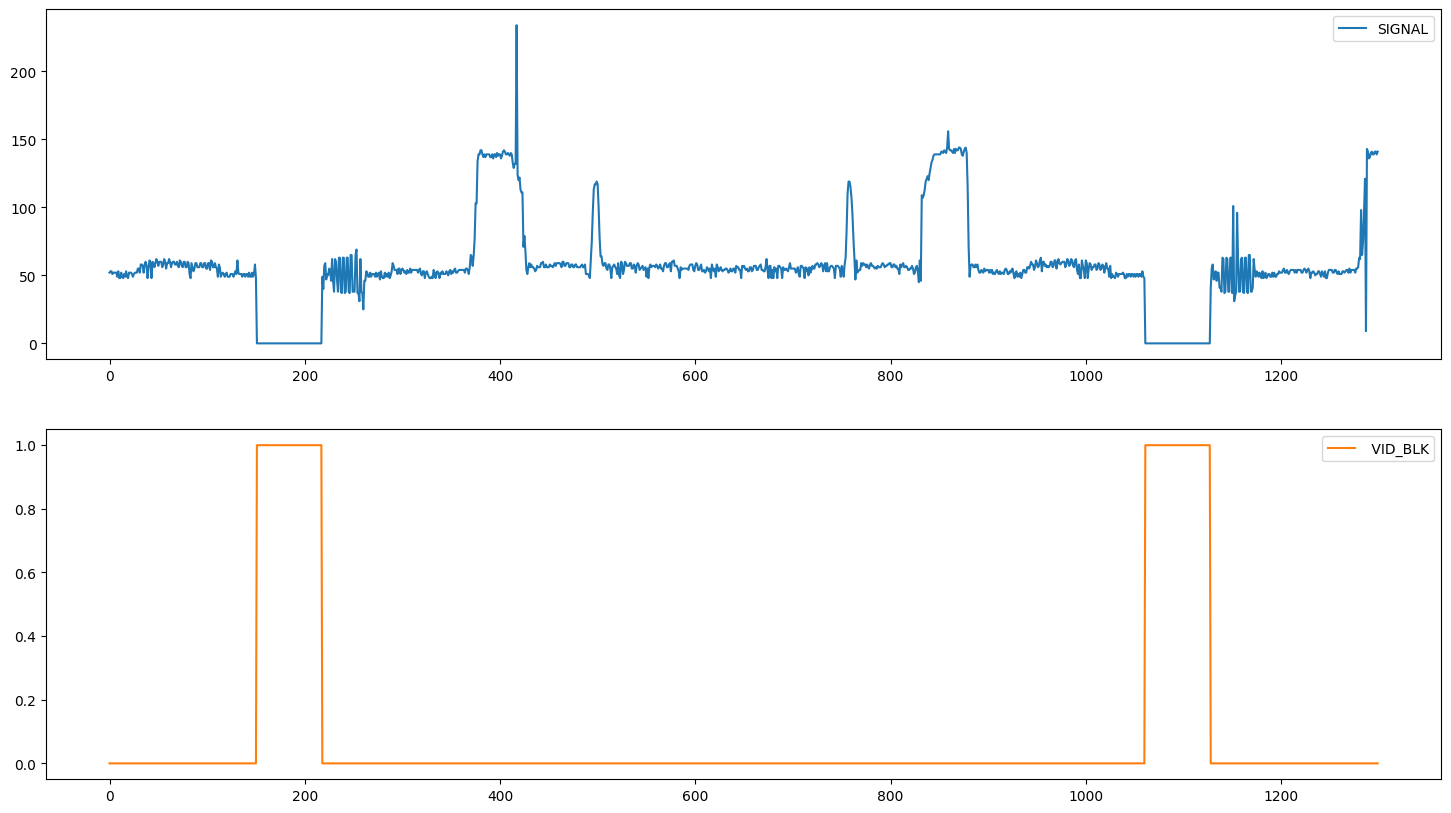

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
dacdf.iloc[:1300].plot(y=['SIGNAL', ' VID_BLK'], subplots=True, ax=ax, use_index=True)

timing of vid signal where falling edge of horizontal sync pulse (blanking) is t=0s  
t=-2.5650us front porch  
t=0us vidblanking  
t=4.6200us back porch  
t=5.3250us colorburst  
t=8.1250us end colorburst  
t=9.6400us begin scanline  
t=61.250us end scanline  

In [72]:
# get start and end indices of each scanline
scanline_start_indices = dacdf[dacdf[' VID_BLK'].diff() == 1].iloc[:-1].index.to_series()
scanline_end_indices = dacdf[dacdf[' VID_BLK'].diff() == 1].iloc[1:].index.to_series() - 1

# a list of dataframes that each contain a single scanline
scanlines = []
for start,end in zip(scanline_start_indices, scanline_end_indices):
    scanline = dacdf.loc[start:end, ['Time[s]', ' VID_BLK', 'VALUE', 'SIGNAL']]
    scanline['datetime'] = pd.to_datetime(scanline['Time[s]'],unit='s')
    scanlines.append(scanline)

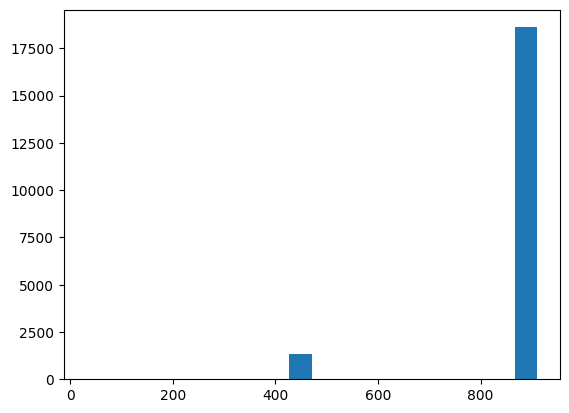

In [35]:
scanline_lengths = [x.shape[0] for x in scanlines]
plt.hist(scanline_lengths, bins=20)
plt.show()

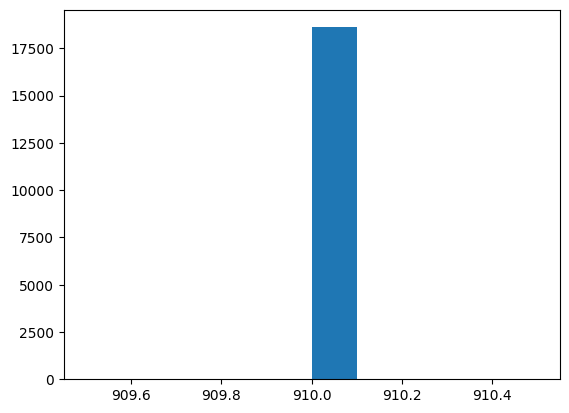

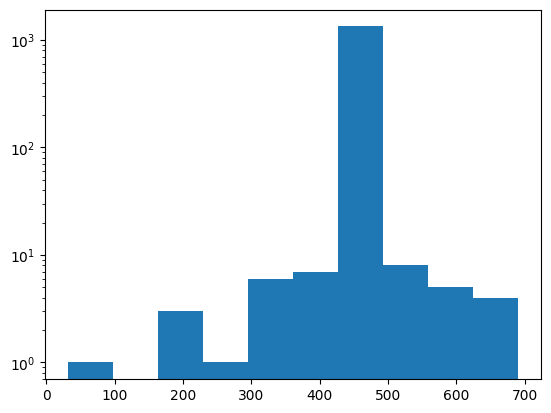

In [52]:
long_scanlines = [x for x in scanline_lengths if x > 700]
short_scanlines = [x for x in scanline_lengths if x < 700]
nbin = 10
plt.hist(long_scanlines,bins=nbin)
plt.show()
plt.hist(short_scanlines,bins=nbin)
plt.yscale('log')
plt.show()

In [37]:
for i in range(len(scanlines)):
    if scanlines[i].shape[0] < 800:
        print(i)

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3270
3271


In [71]:
scanlines[50]

,Time[s],VID_BLK,VALUE,SIGNAL,datetime,STATE,linenumber
37461,0.002616,1,44,0,1970-01-01 00:00:00.002616420,odd_field,38
37462,0.002616,1,51,0,1970-01-01 00:00:00.002616490,odd_field,38
37463,0.002617,1,51,0,1970-01-01 00:00:00.002616560,odd_field,38
37464,0.002617,1,51,0,1970-01-01 00:00:00.002616630,odd_field,38
37465,0.002617,1,51,0,1970-01-01 00:00:00.002616700,odd_field,38
...,...,...,...,...,...,...,...
38366,0.002680,0,49,49,1970-01-01 00:00:00.002679625,odd_field,38
38367,0.002680,0,52,52,1970-01-01 00:00:00.002679695,odd_field,38
38368,0.002680,0,51,51,1970-01-01 00:00:00.002679765,odd_field,38
38369,0.002680,0,57,57,1970-01-01 00:00:00.002679835,odd_field,38


C:\Users\ionca\AppData\Local\Temp\ipykernel_12228\3576649044.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

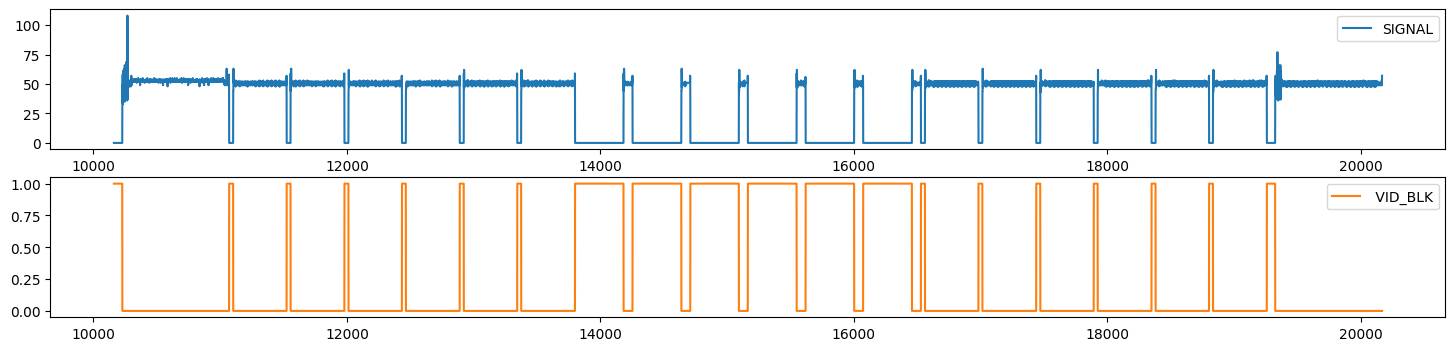

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
vsync = (29-12)//2 + 12 +1
window = 10
pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


C:\Users\ionca\AppData\Local\Temp\ipykernel_12228\4018485476.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

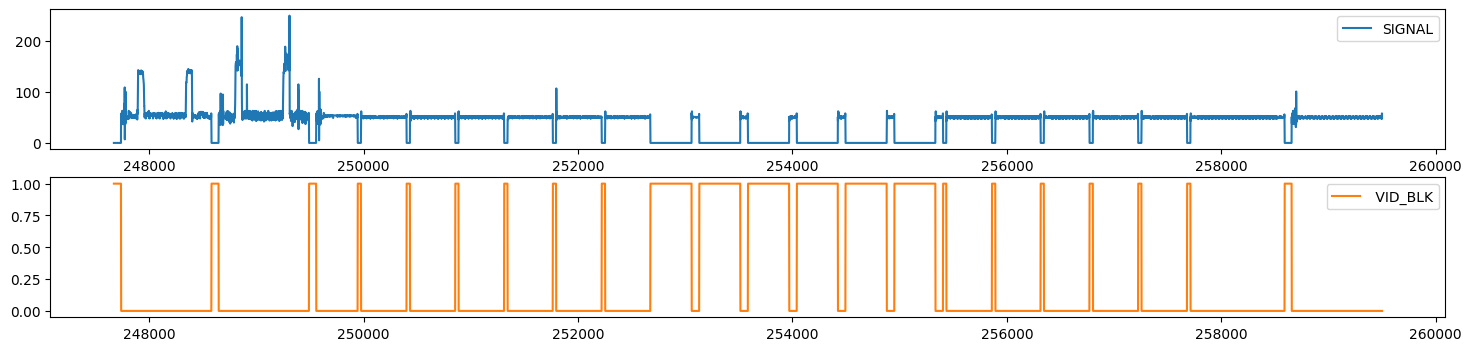

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
vsync = (300-283)//2 + 283 +1
window = 11
pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


In [53]:
print('Even field line widths')
for line in scanlines[282:289]:
    print(len(line[line[' VID_BLK'] == 0]))
print('Odd field line widths')
for line in scanlines[10:17]:
    print(len(line[line[' VID_BLK'] == 0]))


Even field line widths
843
387
425
422
425
422
425
Odd field line widths
843
843
422
425
422
425
422


In [42]:
scanlines[29]['VALUE'][220:]

19025    51
19026    52
19027    52
19028    49
19029    52
         ..
19256    53
19257    49
19258    51
19259    57
19260    49
Name: VALUE, Length: 236, dtype: int64

In [68]:

x = np.arange(0,20)
y = x**2
y2 = -x**2
print(asciichartpy.plot(y, cfg={'height':28}))
clear_output()

In [75]:
import asciichartpy
from IPython.display import clear_output
def determine_signal_states(scanlines:list, line_length_threshold=700):
    updated_scanlines = []
    _scanlines = [line.copy() for line in scanlines]
    # possible states: vsync, vsync_even, vsync_odd, even_field, odd_field, incomplete
    found_first_vsync = False
    linenumber = 0
    last_line = None
    for i in range(len(_scanlines)):
        line = _scanlines[i]
        # DEBUG
        # clear_output()
        # print(asciichartpy.plot(line['SIGNAL'].to_list(), cfg={'height':20}))
        if not found_first_vsync:
            if len(line) > line_length_threshold:
                line['STATE'] = 'incomplete'
                line['linenumber'] = -1
            else:
                found_first_vsync = True
                line['STATE'] = 'vsync'
                linenumber = 0
                line['linenumber'] = linenumber
        else:
            if len(line) > line_length_threshold: # we are not in vsync
                if 'vsync' in last_line['STATE'].iloc[0]: # we just exited vsync
                    line['STATE'] = last_line['STATE'].iloc[0].split('_')[0] + '_field'
                else: # we exited vsync a while ago
                    line['STATE'] = last_line['STATE'].iloc[0]
            else: # we are in vsync
                if 'vsync' in last_line['STATE'].iloc[0]: # we are in vsync
                    if 'vsync' == last_line['STATE'].iloc[0]: # we entered vsync on last line
                        if len(line[line[' VID_BLK'] == 0]) > len(last_line[last_line[' VID_BLK'] == 0]) \
                            and abs(len(line[line[' VID_BLK'] == 0]) - len(last_line[last_line[' VID_BLK'] == 0])) > 10: # we are in even field vsync
                                
                            line['STATE'] = 'even_vsync'
                            updated_scanlines[-1]['STATE'] = 'even_vsync'
                        else: # we are in odd field vsync
                            line['STATE'] = 'odd_vsync'
                            updated_scanlines[-1]['STATE'] = 'odd_vsync'
                    else: # we entered vsync a while ago
                        line['STATE'] = last_line['STATE'].iloc[0]
                else: # we just entered vsync
                    line['STATE'] = 'vsync'
                    linenumber = 0
            
            line['linenumber'] = linenumber
                        
        last_line = line
        updated_scanlines.append(line)
        linenumber += 1
    
    return updated_scanlines

newscanlines = determine_signal_states(scanlines)

In [76]:
print("Even Field")
print(pd.concat(newscanlines[282:289])[['STATE', 'linenumber']])
print("Odd Field")
print(pd.concat(newscanlines[10:17])[['STATE', 'linenumber']])


Even Field
             STATE  linenumber
248581   odd_field         270
248582   odd_field         270
248583   odd_field         270
248584   odd_field         270
248585   odd_field         270
...            ...         ...
252216  even_vsync           5
252217  even_vsync           5
252218  even_vsync           5
252219  even_vsync           5
252220  even_vsync           5

[3640 rows x 2 columns]
Odd Field
            STATE  linenumber
9251   incomplete          -1
9252   incomplete          -1
9253   incomplete          -1
9254   incomplete          -1
9255   incomplete          -1
...           ...         ...
13340   odd_vsync           4
13341   odd_vsync           4
13342   odd_vsync           4
13343   odd_vsync           4
13344   odd_vsync           4

[4094 rows x 2 columns]


In [77]:
fieldsdf = pd.concat(newscanlines)

In [78]:
print(fieldsdf['STATE'].value_counts())

STATE
odd_field     9070880
even_field    7854210
odd_vsync      316680
even_vsync     305760
incomplete      10920
Name: count, dtype: int64


In [79]:
len_state = []
for line in newscanlines:
    len_state.append([len(line), line['STATE'].iloc[0]])
len_state = pd.DataFrame(len_state, columns=['len', 'state'])
len_state.groupby('state').describe()

len                                                          
             count        mean        std    min    25%    50%    75%    max
state                                                                       
even_field  8631.0  910.000000   0.000000  910.0  910.0  910.0  910.0  910.0
even_vsync   672.0  455.000000  10.459916  321.0  454.0  455.0  456.0  589.0
incomplete    12.0  910.000000   0.000000  910.0  910.0  910.0  910.0  910.0
odd_field   9968.0  910.000000   0.000000  910.0  910.0  910.0  910.0  910.0
odd_vsync    697.0  454.347202  32.998214   31.0  454.0  454.0  456.0  691.0

In [81]:
len_state.hist('len', by='state')

array([[<Axes: title={'center': 'even_field'}>,
        <Axes: title={'center': 'even_vsync'}>],
       [<Axes: title={'center': 'incomplete'}>,
        <Axes: title={'center': 'odd_field'}>],
       [<Axes: title={'center': 'odd_vsync'}>, <Axes: >]], dtype=object)

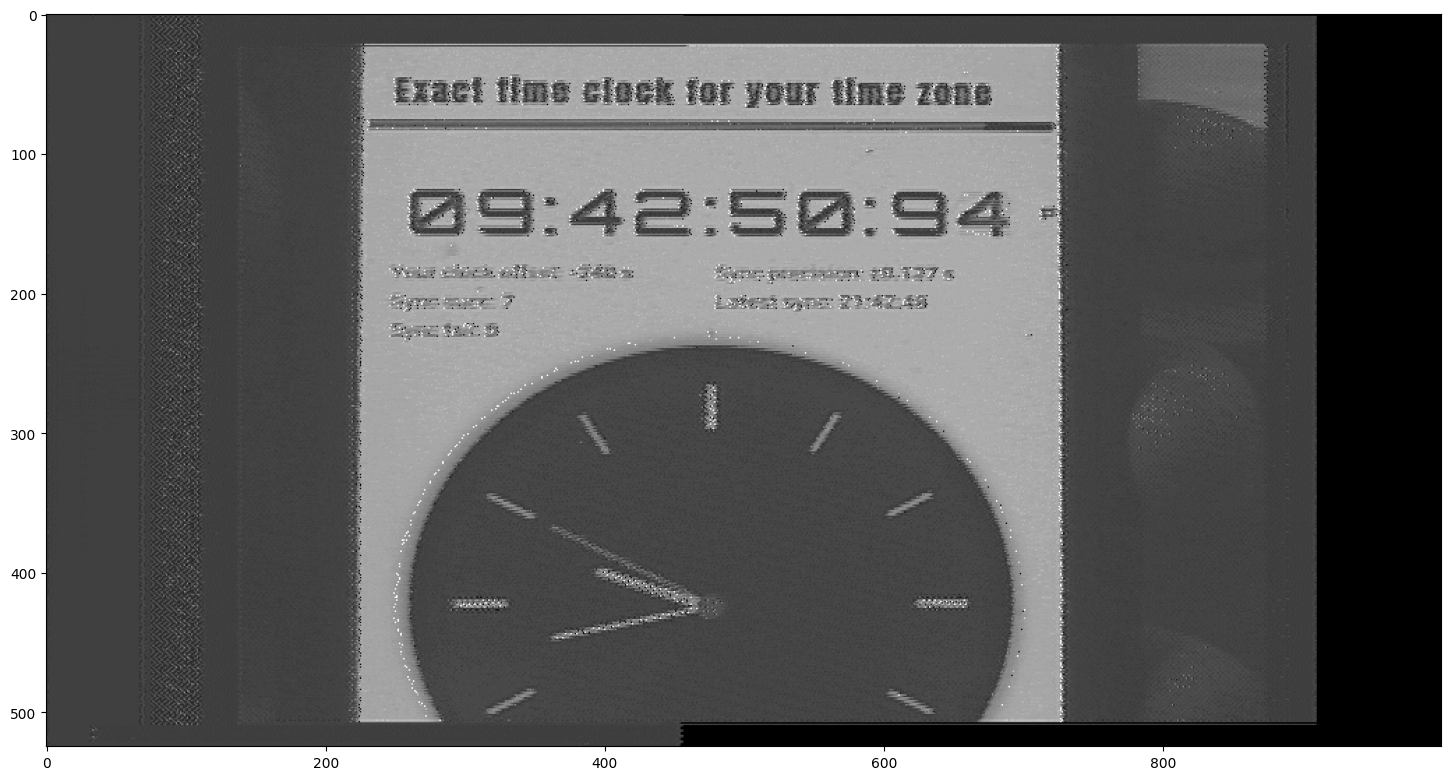

In [28]:
def extract_luma_from_scanlines(scanlines:list):
    scanline_start_offset = 0 # index in each scanline df where the visible part of the image begins
    h = 525
    w = int(4*h/3)+300
    row = 0
    image = np.ndarray((h,w))
    for line in scanlines[29:]:
        luma = line['VALUE'][scanline_start_offset:].to_numpy()
        end_index = len(luma)
        if end_index > w:
            end_index = w
        image[row,:end_index] = luma[:end_index]
        row+=2
        if row >= h:
            break
    
    last_line_index = row//2
    row = 1
    for line in scanlines[29 + last_line_index + 8:]:
        luma = line['VALUE'][scanline_start_offset:].to_numpy()
        end_index = len(luma)
        if end_index > w:
            end_index = w
        image[row,:end_index] = luma[:end_index]
        row+=2
        if row >= h:
            return image      

fig, ax = plt.subplots()
fig.set_size_inches(18,16)
image = extract_luma_from_scanlines(scanlines)
ax.imshow(image, 'Greys_r')
plt.show()